# 📊 Marketing Analytics Dashboard - Interactive Analysis

This notebook provides comprehensive analysis and visualization of marketing performance metrics across multiple channels.

## Overview
- **Data Sources**: Google Analytics, Google Ads, Facebook/Instagram, Email
- **KPIs Tracked**: 25+ metrics including ROAS, CPA, CTR, Conversion Rates
- **Analysis**: Channel performance, trend analysis, target vs actual comparisons

---


In [1]:
# Install required packages if not already installed
import sys
import subprocess

def install_package(package):
    """Install a package if it's not already installed"""
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully!")

# Install plotly if needed
try:
    import plotly
except ImportError:
    install_package("plotly")

# Install other visualization libraries if needed
for package in ["matplotlib", "seaborn"]:
    try:
        __import__(package)
    except ImportError:
        install_package(package)

print("✅ All required packages are available!")


✅ All required packages are available!


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📈 Plotly version: {plotly.__version__}")


✅ Libraries imported successfully!
📊 Pandas version: 2.3.3
📈 Plotly version: 6.5.0


## 1. Data Loading and Exploration


In [3]:
# Load processed metrics data
metrics_df = pd.read_csv('data/processed/dashboard_metrics.csv')
print("📁 Processed Metrics Data:")
print(f"   Shape: {metrics_df.shape}")
print(f"   Columns: {list(metrics_df.columns)}")
print("\n" + "="*50)
metrics_df.head(10)


📁 Processed Metrics Data:
   Shape: (19, 5)
   Columns: ['Date', 'Channel', 'KPI', 'Value', 'Target']



,Date,Channel,KPI,Value,Target
0,2025-12-05,Google Ads,Impressions,125000,100000
1,2025-12-05,Google Ads,Clicks,8750,7000
2,2025-12-05,Google Ads,CTR,7.0%,6.5%
3,2025-12-05,Google Ads,CPC,1.25,1.30
4,2025-12-05,Google Ads,Conversions,425,400
5,2025-12-05,Google Ads,CPA,25.50,27.00
6,2025-12-05,Facebook,Impressions,85000,80000
7,2025-12-05,Facebook,Clicks,5100,4500
8,2025-12-05,Facebook,CTR,6.0%,5.8%
9,2025-12-05,Facebook,CPC,0.95,1.00


In [4]:
# Load raw Google Analytics data
ga_df = pd.read_csv('data/raw/ga_export.csv')
print("📁 Raw Google Analytics Data:")
print(f"   Shape: {ga_df.shape}")
print(f"   Columns: {list(ga_df.columns)}")
print("\n" + "="*50)
ga_df.head(10)


📁 Raw Google Analytics Data:
   Shape: (10, 13)
   Columns: ['date', 'channel', 'campaign', 'impressions', 'clicks', 'conversions', 'cost', 'revenue', 'roi', 'roas', 'ctr', 'cpc', 'cpa']



,date,channel,campaign,impressions,clicks,conversions,cost,revenue,roi,roas,ctr,cpc,cpa
0,2025-02-01,organic,organic_brand,15000,1200,150,0,7500,inf,inf,8.0,0.0,0.0
1,2025-02-01,paid_search,google_search_main,8500,850,85,4250,4250,0.0,1.0,10.0,5.0,50.0
2,2025-02-01,social,facebook_main,12000,480,48,1200,2400,1.0,2.0,4.0,2.5,25.0
3,2025-02-01,social,instagram_main,9500,380,38,950,1900,1.0,2.0,4.0,2.5,25.0
4,2025-02-02,organic,organic_brand,16200,1300,165,0,8250,inf,inf,8.0,0.0,0.0
5,2025-02-02,paid_search,google_search_main,9200,920,92,4600,4600,0.0,1.0,10.0,5.0,50.0
6,2025-02-02,social,facebook_main,13100,524,52,1300,2600,1.0,2.0,4.0,2.5,25.0
7,2025-02-02,social,instagram_main,10200,408,41,1020,2050,1.0,2.0,4.0,2.5,25.0
8,2025-02-03,organic,organic_brand,17500,1400,180,0,9000,inf,inf,8.0,0.0,0.0
9,2025-02-03,paid_search,google_search_main,10000,1000,100,5000,5000,0.0,1.0,10.0,5.0,50.0


## 2. Data Preprocessing and Cleaning


In [5]:
# Helper function to extract numeric values
def extract_numeric(value):
    """Extract numeric value from string (handles %, commas, etc.)"""
    if pd.isna(value):
        return 0
    if isinstance(value, (int, float)):
        return float(value)
    # Remove % and commas
    value_str = str(value).replace('%', '').replace(',', '').strip()
    try:
        return float(value_str)
    except:
        return 0

# Create a cleaned version of metrics data
metrics_clean = metrics_df.copy()
metrics_clean['Value_Numeric'] = metrics_clean['Value'].apply(extract_numeric)
metrics_clean['Target_Numeric'] = metrics_clean['Target'].apply(extract_numeric)
metrics_clean['Performance_Ratio'] = metrics_clean['Value_Numeric'] / metrics_clean['Target_Numeric'].replace(0, np.nan)

print("✅ Data cleaned and numeric columns created")
print(f"\n📊 Summary Statistics:")
print(metrics_clean[['Value_Numeric', 'Target_Numeric', 'Performance_Ratio']].describe())


✅ Data cleaned and numeric columns created

📊 Summary Statistics:
       Value_Numeric  Target_Numeric  Performance_Ratio
count      19.000000       19.000000          19.000000
mean    25793.339474    23305.268421           1.086092
std     46244.528158    42053.720774           0.111002
min         0.950000        1.000000           0.933333
25%         9.500000        8.250000           0.998011
50%      4200.000000     3800.000000           1.071429
75%     25000.000000    21000.000000           1.183333
max    157500.000000   150000.000000           1.250000


## 3. Key Performance Indicators (KPIs) Summary


In [6]:
# Calculate overall KPIs
overall_metrics = metrics_clean[metrics_clean['Channel'] == 'Overall']

kpi_summary = {}
for _, row in overall_metrics.iterrows():
    kpi_name = row['KPI']
    kpi_summary[kpi_name] = {
        'Value': row['Value_Numeric'],
        'Target': row['Target_Numeric'],
        'Performance': row['Performance_Ratio']
    }

# Display KPI Summary
print("🎯 KEY PERFORMANCE INDICATORS")
print("="*60)
for kpi, data in kpi_summary.items():
    value = data['Value']
    target = data['Target']
    perf = data['Performance']
    status = "✅" if perf >= 1.0 else "⚠️"
    print(f"{status} {kpi:20s}: ${value:>12,.0f} (Target: ${target:>12,.0f}) | Ratio: {perf:.2%}")

# Calculate ROAS
roas = kpi_summary.get('ROAS', {}).get('Value', 0)
revenue = kpi_summary.get('Total Revenue', {}).get('Value', 0)
cost = kpi_summary.get('Total Cost', {}).get('Value', 0)

print("\n" + "="*60)
print(f"📈 Return on Ad Spend (ROAS): {roas:.2f}")
print(f"💰 Total Revenue: ${revenue:,.0f}")
print(f"💵 Total Cost: ${cost:,.0f}")
if cost > 0:
    print(f"📊 Revenue/Cost Ratio: {revenue/cost:.2f}")


🎯 KEY PERFORMANCE INDICATORS
✅ ROAS                : $           4 (Target: $           4) | Ratio: 107.14%
✅ Total Revenue       : $     157,500 (Target: $     150,000) | Ratio: 105.00%
⚠️ Total Cost          : $      42,000 (Target: $      45,000) | Ratio: 93.33%

📈 Return on Ad Spend (ROAS): 3.75
💰 Total Revenue: $157,500
💵 Total Cost: $42,000
📊 Revenue/Cost Ratio: 3.75


## 4. Channel Performance Analysis


In [7]:
# Analyze performance by channel
channels = metrics_clean['Channel'].unique()
channel_performance = {}

for channel in channels:
    if channel == 'Overall':
        continue
    channel_data = metrics_clean[metrics_clean['Channel'] == channel]
    channel_performance[channel] = {
        'KPIs': len(channel_data),
        'Avg_Performance_Ratio': channel_data['Performance_Ratio'].mean(),
        'Metrics': {}
    }
    
    # Extract key metrics for each channel
    for _, row in channel_data.iterrows():
        kpi = row['KPI']
        channel_performance[channel]['Metrics'][kpi] = {
            'Value': row['Value_Numeric'],
            'Target': row['Target_Numeric']
        }

# Display channel performance
print("📊 CHANNEL PERFORMANCE SUMMARY")
print("="*70)
for channel, data in channel_performance.items():
    print(f"\n🔹 {channel}")
    print(f"   Average Performance Ratio: {data['Avg_Performance_Ratio']:.2%}")
    print(f"   Metrics Tracked: {data['KPIs']}")
    for kpi, metrics in data['Metrics'].items():
        value = metrics['Value']
        target = metrics['Target']
        status = "✅" if value >= target else "⚠️"
        print(f"   {status} {kpi:20s}: {value:>12,.0f} (Target: {target:>12,.0f})")


📊 CHANNEL PERFORMANCE SUMMARY

🔹 Google Ads
   Average Performance Ratio: 109.09%
   Metrics Tracked: 6
   ✅ Impressions         :      125,000 (Target:      100,000)
   ✅ Clicks              :        8,750 (Target:        7,000)
   ✅ CTR                 :            7 (Target:            6)
   ⚠️ CPC                 :            1 (Target:            1)
   ✅ Conversions         :          425 (Target:          400)
   ⚠️ CPA                 :           26 (Target:           27)

🔹 Facebook
   Average Performance Ratio: 104.51%
   Metrics Tracked: 4
   ✅ Impressions         :       85,000 (Target:       80,000)
   ✅ Clicks              :        5,100 (Target:        4,500)
   ✅ CTR                 :            6 (Target:            6)
   ⚠️ CPC                 :            1 (Target:            1)

🔹 Organic
   Average Performance Ratio: 112.78%
   Metrics Tracked: 3
   ✅ Sessions            :       15,000 (Target:       12,000)
   ✅ Users               :       12,000 (Target:       10

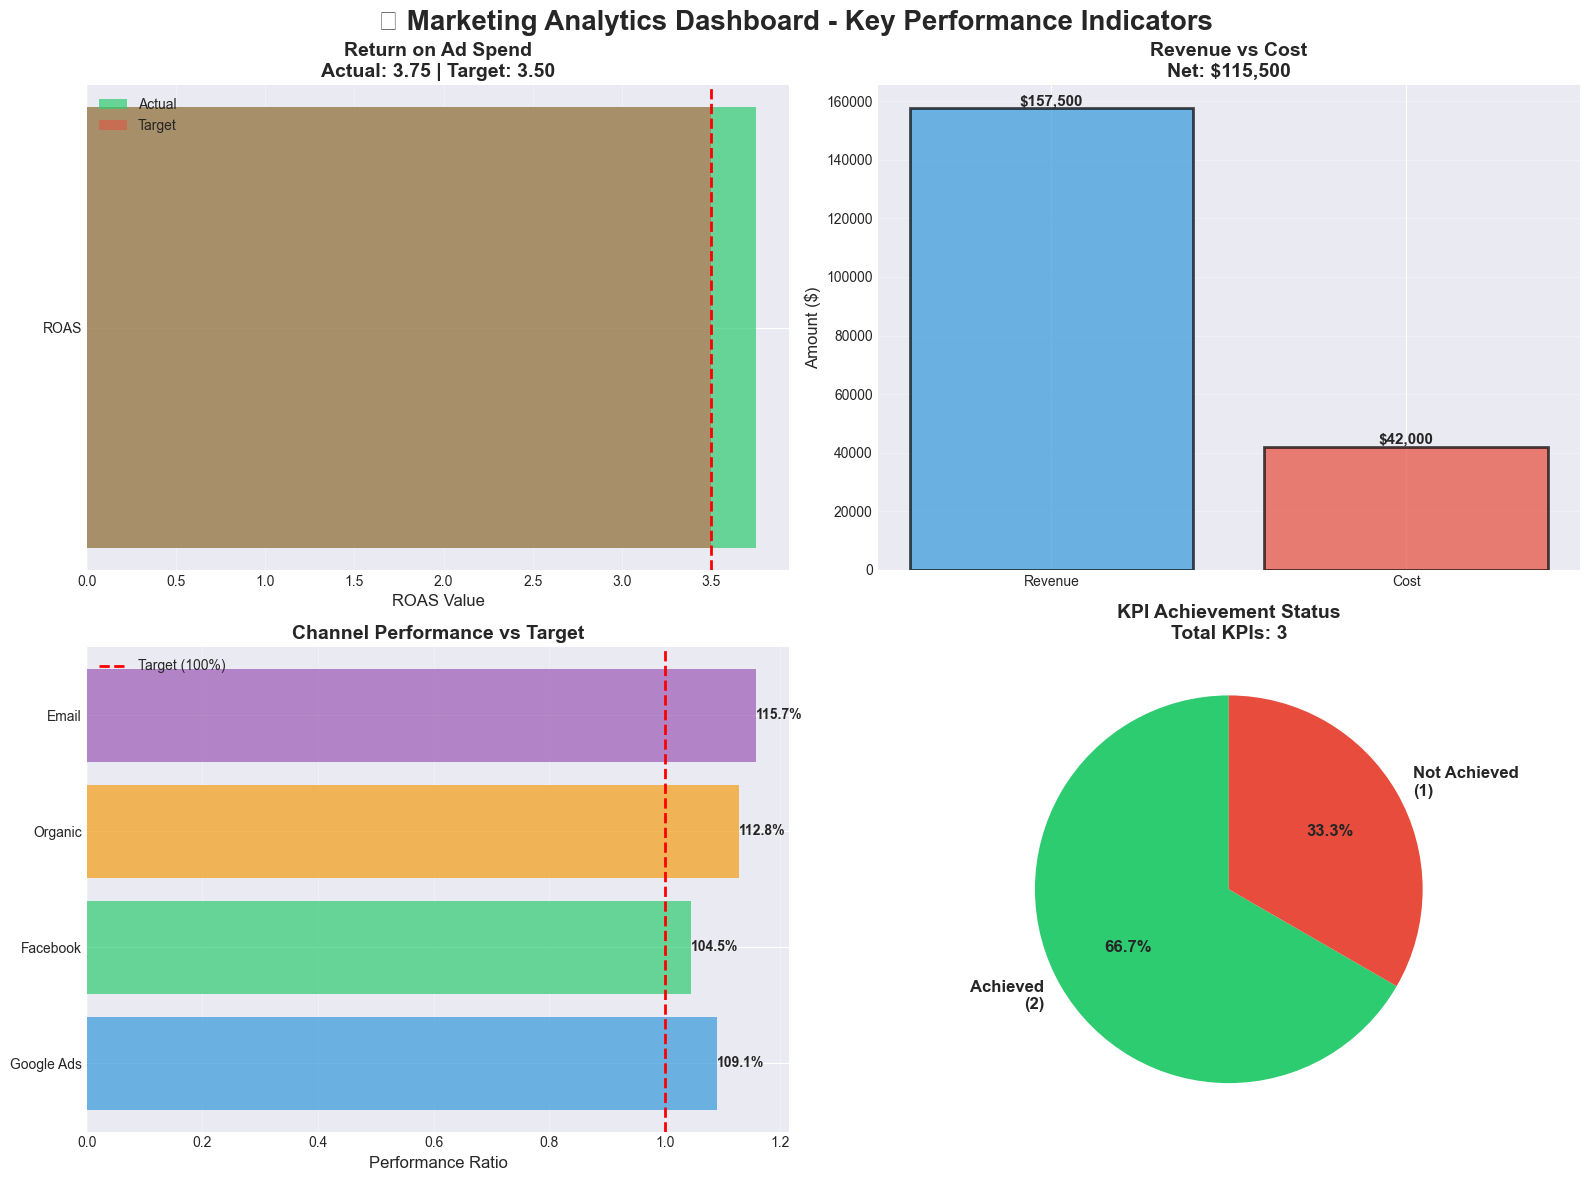

In [8]:
# Create KPI cards visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Marketing Analytics Dashboard - Key Performance Indicators', 
             fontsize=20, fontweight='bold', y=0.98)

# 1. ROAS
ax1 = axes[0, 0]
roas_value = kpi_summary.get('ROAS', {}).get('Value', 0)
roas_target = kpi_summary.get('ROAS', {}).get('Target', 0)
ax1.barh(['ROAS'], [roas_value], color='#2ecc71', alpha=0.7, label='Actual')
ax1.barh(['ROAS'], [roas_target], color='#e74c3c', alpha=0.5, label='Target')
ax1.axvline(roas_target, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('ROAS Value', fontsize=12)
ax1.set_title(f'Return on Ad Spend\nActual: {roas_value:.2f} | Target: {roas_target:.2f}', 
              fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# 2. Revenue vs Cost
ax2 = axes[0, 1]
revenue = kpi_summary.get('Total Revenue', {}).get('Value', 0)
cost = kpi_summary.get('Total Cost', {}).get('Value', 0)
categories = ['Revenue', 'Cost']
values = [revenue, cost]
colors = ['#3498db', '#e74c3c']
bars = ax2.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Amount ($)', fontsize=12)
ax2.set_title(f'Revenue vs Cost\nNet: ${revenue-cost:,.0f}', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${val:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Channel Performance Comparison
ax3 = axes[1, 0]
channel_names = [ch for ch in channel_performance.keys()]
avg_performance = [channel_performance[ch]['Avg_Performance_Ratio'] for ch in channel_names]
colors_ch = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']
bars = ax3.barh(channel_names, avg_performance, color=colors_ch[:len(channel_names)], alpha=0.7)
ax3.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Target (100%)')
ax3.set_xlabel('Performance Ratio', fontsize=12)
ax3.set_title('Channel Performance vs Target', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)
# Add value labels
for bar, val in zip(bars, avg_performance):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f'{val:.1%}', ha='left', va='center', fontsize=10, fontweight='bold')

# 4. KPI Achievement Status
ax4 = axes[1, 1]
achieved = sum(1 for kpi, data in kpi_summary.items() if data['Performance'] >= 1.0)
total = len(kpi_summary)
not_achieved = total - achieved
sizes = [achieved, not_achieved]
labels = [f'Achieved\n({achieved})', f'Not Achieved\n({not_achieved})']
colors_pie = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax4.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                    startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax4.set_title(f'KPI Achievement Status\nTotal KPIs: {total}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [9]:
# Create interactive dashboard with Plotly
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Channel Clicks Comparison', 'KPI Performance vs Target', 
                    'Revenue & Cost Trend', 'Conversion Metrics'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# 1. Channel Clicks
channel_clicks = {}
for channel in channel_performance.keys():
    clicks_data = channel_performance[channel]['Metrics'].get('Clicks', {})
    if clicks_data:
        channel_clicks[channel] = clicks_data['Value']

if channel_clicks:
    fig.add_trace(
        go.Bar(x=list(channel_clicks.keys()), y=list(channel_clicks.values()),
               name='Clicks', marker_color='#3498db', showlegend=False),
        row=1, col=1
    )

# 2. KPI Performance vs Target
kpi_names = list(kpi_summary.keys())
kpi_values = [kpi_summary[k]['Value'] for k in kpi_names]
kpi_targets = [kpi_summary[k]['Target'] for k in kpi_names]

fig.add_trace(
    go.Bar(x=kpi_names, y=kpi_values, name='Actual', marker_color='#2ecc71'),
    row=1, col=2
)
fig.add_trace(
    go.Bar(x=kpi_names, y=kpi_targets, name='Target', marker_color='#e74c3c'),
    row=1, col=2
)

# 3. Revenue & Cost
fig.add_trace(
    go.Bar(x=['Revenue', 'Cost'], y=[revenue, cost], 
           name='Amount', marker_color=['#2ecc71', '#e74c3c'], showlegend=False),
    row=2, col=1
)

# 4. Conversion Metrics by Channel
conversion_metrics = {}
for channel in channel_performance.keys():
    conv_rate = channel_performance[channel]['Metrics'].get('Conversion Rate', {})
    if conv_rate:
        conversion_metrics[channel] = conv_rate['Value']

if conversion_metrics:
    fig.add_trace(
        go.Scatter(x=list(conversion_metrics.keys()), 
                  y=list(conversion_metrics.values()),
                  mode='lines+markers', name='Conversion Rate',
                  marker=dict(size=10, color='#9b59b6'),
                  line=dict(width=3)),
        row=2, col=2
    )

# Update layout
fig.update_layout(
    height=800,
    title_text="📊 Interactive Marketing Analytics Dashboard",
    title_x=0.5,
    title_font_size=20,
    showlegend=True,
    template='plotly_white'
)

# Update axes
fig.update_xaxes(title_text="Channel", row=1, col=1)
fig.update_yaxes(title_text="Clicks", row=1, col=1)
fig.update_xaxes(title_text="KPI", row=1, col=2)
fig.update_yaxes(title_text="Value", row=1, col=2)
fig.update_xaxes(title_text="Metric", row=2, col=1)
fig.update_yaxes(title_text="Amount ($)", row=2, col=1)
fig.update_xaxes(title_text="Channel", row=2, col=2)
fig.update_yaxes(title_text="Conversion Rate (%)", row=2, col=2)

fig.show()


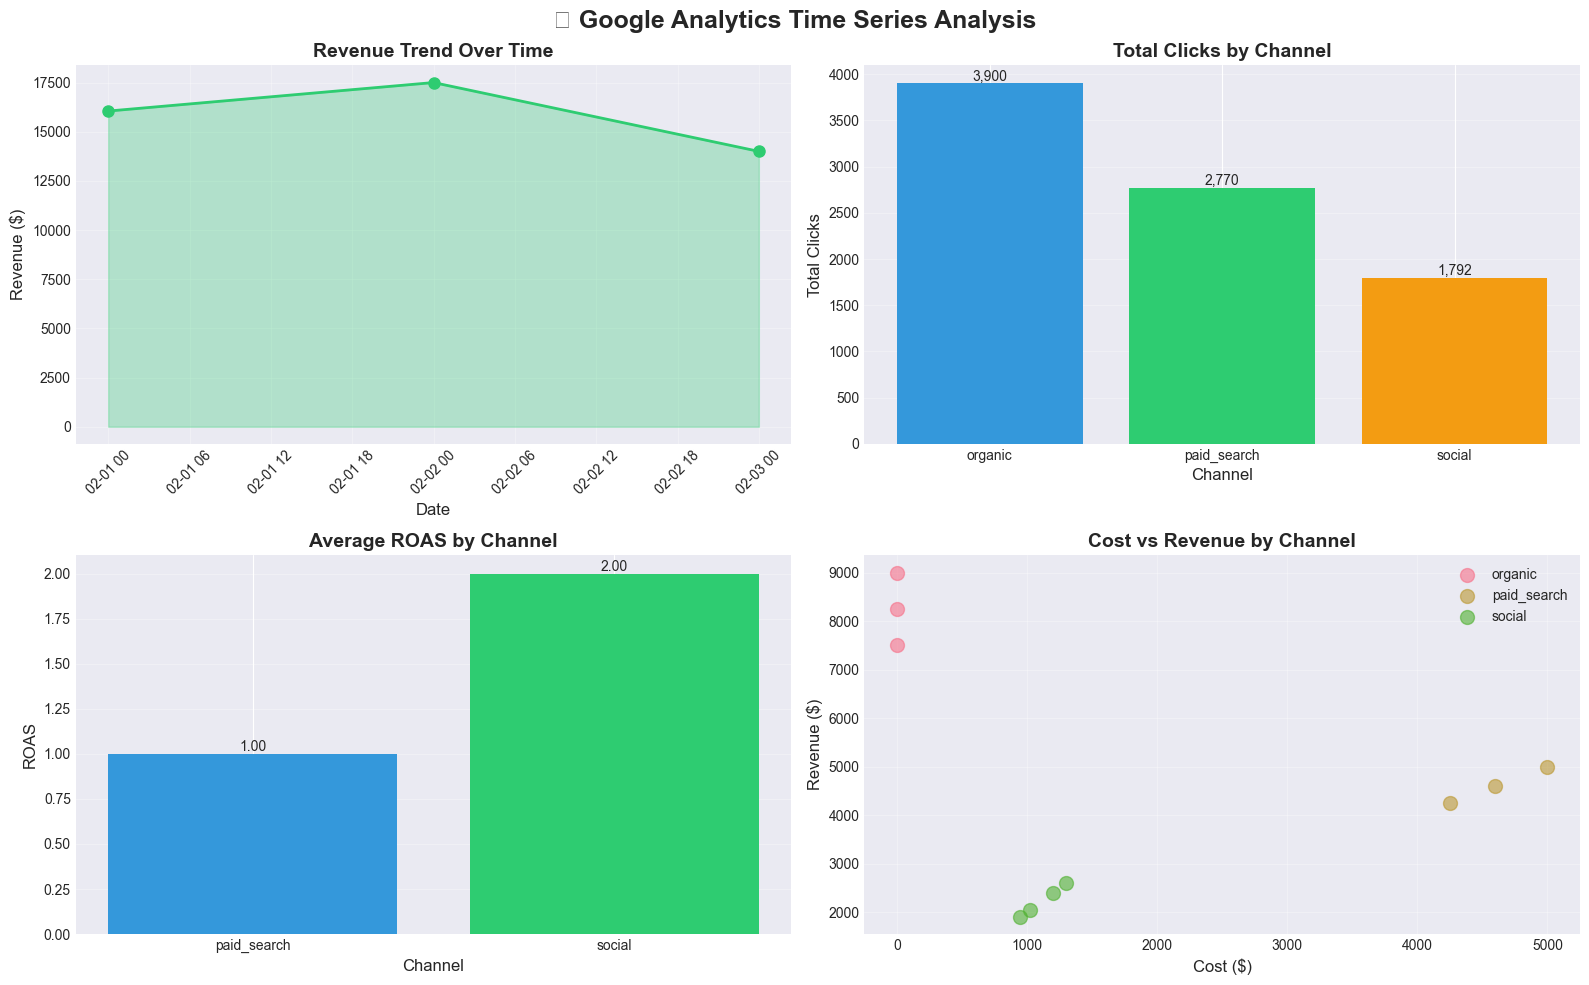

In [10]:
# Analyze time series data from GA export
if not ga_df.empty:
    ga_df['date'] = pd.to_datetime(ga_df['date'])
    ga_df_sorted = ga_df.sort_values('date')
    
    # Create time series visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('📈 Google Analytics Time Series Analysis', fontsize=18, fontweight='bold')
    
    # 1. Revenue Trend
    ax1 = axes[0, 0]
    revenue_by_date = ga_df_sorted.groupby('date')['revenue'].sum()
    ax1.plot(revenue_by_date.index, revenue_by_date.values, marker='o', linewidth=2, 
             color='#2ecc71', markersize=8)
    ax1.fill_between(revenue_by_date.index, revenue_by_date.values, alpha=0.3, color='#2ecc71')
    ax1.set_title('Revenue Trend Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Revenue ($)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Clicks by Channel
    ax2 = axes[0, 1]
    clicks_by_channel = ga_df_sorted.groupby('channel')['clicks'].sum().sort_values(ascending=False)
    bars = ax2.bar(clicks_by_channel.index, clicks_by_channel.values, 
                   color=['#3498db', '#2ecc71', '#f39c12', '#9b59b6'][:len(clicks_by_channel)])
    ax2.set_title('Total Clicks by Channel', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Channel', fontsize=12)
    ax2.set_ylabel('Total Clicks', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10)
    
    # 3. ROAS by Channel
    ax3 = axes[1, 0]
    roas_by_channel = ga_df_sorted.groupby('channel')['roas'].mean()
    # Handle inf values
    roas_by_channel = roas_by_channel.replace([np.inf, -np.inf], np.nan).dropna()
    if len(roas_by_channel) > 0:
        bars = ax3.bar(roas_by_channel.index, roas_by_channel.values,
                      color=['#3498db', '#2ecc71', '#f39c12', '#9b59b6'][:len(roas_by_channel)])
        ax3.set_title('Average ROAS by Channel', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Channel', fontsize=12)
        ax3.set_ylabel('ROAS', fontsize=12)
        ax3.grid(axis='y', alpha=0.3)
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if not np.isinf(height) and not np.isnan(height):
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=10)
    
    # 4. Cost vs Revenue Scatter
    ax4 = axes[1, 1]
    for channel in ga_df_sorted['channel'].unique():
        channel_data = ga_df_sorted[ga_df_sorted['channel'] == channel]
        ax4.scatter(channel_data['cost'], channel_data['revenue'], 
                   label=channel, s=100, alpha=0.6)
    ax4.set_title('Cost vs Revenue by Channel', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Cost ($)', fontsize=12)
    ax4.set_ylabel('Revenue ($)', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No time series data available for analysis")


## 6. Detailed Analysis and Insights


In [11]:
# Generate insights
print("🔍 KEY INSIGHTS & ANALYSIS")
print("="*70)

# 1. Best performing channel
if channel_performance:
    best_channel = max(channel_performance.items(), 
                      key=lambda x: x[1]['Avg_Performance_Ratio'])
    print(f"\n✅ Best Performing Channel: {best_channel[0]}")
    print(f"   Performance Ratio: {best_channel[1]['Avg_Performance_Ratio']:.2%}")

# 2. ROAS Analysis
if roas > 0:
    print(f"\n📈 ROAS Analysis:")
    print(f"   Current ROAS: {roas:.2f}")
    print(f"   Target ROAS: {kpi_summary.get('ROAS', {}).get('Target', 0):.2f}")
    if roas >= kpi_summary.get('ROAS', {}).get('Target', 0):
        print(f"   ✅ ROAS target achieved!")
    else:
        gap = kpi_summary.get('ROAS', {}).get('Target', 0) - roas
        print(f"   ⚠️ ROAS below target by {gap:.2f}")

# 3. Cost Efficiency
if cost > 0 and revenue > 0:
    efficiency = revenue / cost
    print(f"\n💰 Cost Efficiency:")
    print(f"   Revenue/Cost Ratio: {efficiency:.2f}")
    print(f"   For every $1 spent, we generate ${efficiency:.2f} in revenue")

# 4. Channel Recommendations
print(f"\n💡 Recommendations:")
for channel, data in channel_performance.items():
    perf_ratio = data['Avg_Performance_Ratio']
    if perf_ratio < 0.9:
        print(f"   ⚠️ {channel}: Underperforming ({perf_ratio:.1%}) - Consider optimization")
    elif perf_ratio > 1.1:
        print(f"   ✅ {channel}: Exceeding targets ({perf_ratio:.1%}) - Consider scaling up")
    else:
        print(f"   ✓ {channel}: Meeting targets ({perf_ratio:.1%})")


🔍 KEY INSIGHTS & ANALYSIS

✅ Best Performing Channel: Email
   Performance Ratio: 115.73%

📈 ROAS Analysis:
   Current ROAS: 3.75
   Target ROAS: 3.50
   ✅ ROAS target achieved!

💰 Cost Efficiency:
   Revenue/Cost Ratio: 3.75
   For every $1 spent, we generate $3.75 in revenue

💡 Recommendations:
   ✓ Google Ads: Meeting targets (109.1%)
   ✓ Facebook: Meeting targets (104.5%)
   ✅ Organic: Exceeding targets (112.8%) - Consider scaling up
   ✅ Email: Exceeding targets (115.7%) - Consider scaling up


## 7. Export Summary Report


In [12]:
# Create summary report DataFrame
summary_data = []

# Overall KPIs
for kpi, data in kpi_summary.items():
    summary_data.append({
        'Category': 'Overall',
        'Metric': kpi,
        'Value': data['Value'],
        'Target': data['Target'],
        'Performance': f"{data['Performance']:.2%}"
    })

# Channel KPIs
for channel, data in channel_performance.items():
    for kpi, metrics in data['Metrics'].items():
        summary_data.append({
            'Category': channel,
            'Metric': kpi,
            'Value': metrics['Value'],
            'Target': metrics['Target'],
            'Performance': f"{(metrics['Value']/metrics['Target']):.2%}" if metrics['Target'] > 0 else "N/A"
        })

summary_df = pd.DataFrame(summary_data)
print("📋 SUMMARY REPORT")
print("="*70)
print(summary_df.to_string(index=False))

# Optionally save to CSV
# summary_df.to_csv('marketing_analytics_summary.csv', index=False)
# print("\n✅ Summary report saved to 'marketing_analytics_summary.csv'")


📋 SUMMARY REPORT
  Category          Metric     Value   Target Performance
   Overall            ROAS      3.75      3.5     107.14%
   Overall   Total Revenue 157500.00 150000.0     105.00%
   Overall      Total Cost  42000.00  45000.0      93.33%
Google Ads     Impressions 125000.00 100000.0     125.00%
Google Ads          Clicks   8750.00   7000.0     125.00%
Google Ads             CTR      7.00      6.5     107.69%
Google Ads             CPC      1.25      1.3      96.15%
Google Ads     Conversions    425.00    400.0     106.25%
Google Ads             CPA     25.50     27.0      94.44%
  Facebook     Impressions  85000.00  80000.0     106.25%
  Facebook          Clicks   5100.00   4500.0     113.33%
  Facebook             CTR      6.00      5.8     103.45%
  Facebook             CPC      0.95      1.0      95.00%
   Organic        Sessions  15000.00  12000.0     125.00%
   Organic           Users  12000.00  10000.0     120.00%
   Organic     Bounce Rate     42.00     45.0      93.3

---

## 📝 Notes

- This notebook provides comprehensive analysis of marketing performance metrics
- All visualizations are interactive when using Plotly
- Data can be refreshed by re-running the data loading cells
- For automated updates, use the `dashboard_automation.py` script

## 🔗 Next Steps

1. **Deploy Web Dashboard**: Use `app.py` with Streamlit for online access
2. **Schedule Updates**: Set up automated data refresh using Apache Airflow
3. **Export Reports**: Generate PDF reports from this notebook
4. **Share Insights**: Use visualizations for stakeholder presentations

---

**Created for**: Marketing Analytics Dashboard Project  
**Author**: Nagendra Singh Rawat | Data Science & Analytics Professional
